In [1]:
import json, ast

In [4]:
# import the required libraries
import numpy as np
import time
import random
import pickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

# Exploring stroke data from a-painter

In [6]:
filename = "paintings/dancer.json"

In [89]:
f = open(filename, 'r')
s = ''.join([line.strip() for line in f])
t = json.loads(s)
drawing = ast.literal_eval(json.dumps(t)) # to remove unicode identifiers
f.close()

In [90]:
#TODO: add smoothing
prev_pos = random.uniform(-0.01, 0.01)
for i in range(len(drawing['strokes'])): # go per stroke
    lst = [random.uniform(-1,1)] * 4 # for a particular stroke, I want all orientation to be the same
    prev_pos = prev_pos + random.uniform(-0.001, 0.001)
    for j in range(len(drawing['strokes'][i]['points'])): # go per point in that stroke
        drawing['strokes'][i]['points'][j]['position'][2] = prev_pos 
        for k in range(len(drawing['strokes'][i]['points'][j]['orientation'])):
            drawing['strokes'][i]['points'][j]['orientation'][k] = lst[k] + random.uniform(-0.001,0.001) # very subtle difference to account for hand movement!
        
        

In [91]:
f2 = open('paintings/orientation_0.json', 'w')
f2.write(json.dumps(drawing))
f2.close()

In [53]:
random.random()

0.10995057416708354

# SketchRNN input-output

In [15]:
# !curl http://localhost:8080/simple_predict?strokes=[[1,2,1,0,0],[4,19,1,0,0],[19,27,1,0,0],[17,8,1,0,0],[28,0,1,0,0],[12,-7,1,0,0],[14,-15,1,0,0],[10,-26,1,0,0],[0,-18,1,0,0],[-5,-13,1,0,0],[-11,-13,1,0,0],[-20,-9,1,0,0],[-14,0,1,0,0],[-42,18,1,0,0],[-11,15,1,0,0],[-2,15,0,1,0]]

curl: (3) [globbing] bad range specification in column 47


In [25]:
inp = [[1,2,1,0,0],[4,19,1,0,0],[19,27,1,0,0],[17,8,1,0,0],[28,0,1,0,0],[12,-7,1,0,0],[14,-15,1,0,0],[10,-26,1,0,0],[0,-18,1,0,0],[-5,-13,1,0,0],[-11,-13,1,0,0],[-20,-9,1,0,0],[-14,0,1,0,0],[-42,18,1,0,0],[-11,15,1,0,0],[-2,15,0,1,0]]
a = [[31.258453915660947,-26.837807949903826,1,0,0],[3.6818529304712095,4.896104994796764,1,0,0],[4.957045247944361,4.2405723564438,1,0,0],[11.688273372884394,6.121526260591747,1,0,0],[8.647588408746115,1.9675724205741667,1,0,0],[6.3142729642796915,-0.07823511936606546,1,0,0],[6.781217209544944,-1.7340049855060171,1,0,0],[8.09247084406152,-4.3762558487269825,1,0,0],[8.924907395277748,-8.719216822557506,1,0,0],[3.2296317756526483,-4.932783894149657,1,0,0],[4.291306628340996,-11.071659712716166,1,0,0],[0.5357900024291374,-4.099396423200803,1,0,0],[-0.7653107450906215,-3.1294441897128116,1,0,0],[-2.751143650667369,-4.401337657014864,1,0,0],[-2.350830124618998,-2.377929298487632,1,0,0],[-6.125943884802458,-3.591200379640914,1,0,0],[-4.957249914111485,-1.718906391274197,1,0,0],[-5.756654188372424,-0.8278394108133164,1,0,0],[-20.64759834647727,2.4726289267220833,1,0,0],[-3.794850756554839,1.023672929637542,1,0,0],[-11.804380520448134,7.519138928523418,1,0,0],[-5.571998071113797,7.188440395335293,1,0,0],[-3.089169473450947,8.081061825567271,1,0,0],[-0.290689188495207,3.3857671471160624,1,0,0],[0.7311920509982852,1.8524504172308702,1,0,0],[2.812953645999795,2.187143618714405,1,0,0],[7.312289000343045,2.353342309541952,1,0,0],[23.461267295593338,-1.6822734018548913,1,0,0],[14.121800718098315,-6.2172544351659,1,0,0],[9.608856463090014,-8.856535433109526,1,0,0],[0.7862436657996849,-1.9867280769666686,1,0,0],[-0.6030753744384898,-2.3528357979806285,1,0,0],[-22.103871638812453,-2.2541587988187657,1,0,0],[-8.620344700491028,1.8922053147998248,0,1,0],[6.918672348793206,10.489857872652046,1,0,0],[1.5576002961571476,3.618340347796483,1,0,0],[11.053008217285626,12.316231736656016,1,0,0],[9.787446771786792,6.786183868450883,1,0,0],[-4.165509273738993,-11.367397322142335,1,0,0],[-0.9264771430273334,-8.342979121664804,1,0,0],[-0.6272730332075327,-3.9316960689212093,1,0,0],[0.5055170210664058,-2.779436549716231,0,1,0],[-37.89786683871435,72.41776070362265,1,0,0],[-2.5148362581319064,5.1437730750086565,1,0,0],[-3.232330712338513,12.527745108507588,1,0,0],[-6.763135991724409,17.99784437251836,1,0,0],[-2.019690102426197,0.12043455561546278,0,1,0],[1.246044546967006,-3.404475540000797,1,0,0],[-6.468333594982752,3.2895818098261516,1,0,0],[-11.000706219834651,7.527458139703411,0,1,0],[19.773496186292128,-9.931774500889903,1,0,0],[2.1008850530010146,5.404631343264552,1,0,0],[3.4418740534834407,4.881871660673144,1,0,0],[4.571837673006872,4.6331859958425525,0,1,0],[-6.880691733323818,-12.901678968306818,1,0,0],[5.814791428169642,15.338019488666122,1,0,0],[1.7324019541261442,2.495756829193112,1,0,0],[2.019902894074925,0.5610601652552973,0,1,0],[34.190640732254444,-43.20245779312776,1,0,0],[-2.4326743034865657,10.895800070743912,1,0,0],[-1.0812786648733121,18.67788908538621,1,0,0],[-1.471860202874604,4.621004867524296,0,1,0],[-0.9554036234242462,-2.1317759094961795,1,0,0],[-3.2202917000369453,4.361120596210118,1,0,0],[-3.51772579963493,6.781137237150038,1,0,0],[-1.5751466900632458,5.11255697512293,0,1,0],[11.537133853304983,-15.675006570154913,1,0,0],[2.9072849157937948,4.711714392904047,1,0,0],[6.086542115368435,5.414478923180122,1,0,0],[4.159079052100171,2.1076520244907155,0,1,0],[-14.442261721351972,-10.330633225116394,1,0,0],[-0.20527319118638074,8.789616920711394,1,0,0],[1.6604023513821198,11.178063718271888,0,1,0],[-39.565348330896114,-133.41692961197035,1,0,0],[-0.5223570316507702,3.085451862247158,1,0,0],[-6.529578512668542,9.196073871591398,1,0,0],[-14.877378591402088,16.95555454947635,1,0,0],[-19.248576727577316,19.088794246792816,1,0,0],[-8.35861186447168,5.626558682531559,0,1,0],[72.16306028266972,-60.14108881455933,0,0,1]]

In [26]:
import matplotlib.pyplot as plt
def draw_strokes(lst_strokes):
    i = 0
    xs = []
    ys = []
    last_x = 283
    last_y = 281
    while i < len(lst_strokes):
        if lst_strokes[i][3] != 1:
            xs.append(last_x - lst_strokes[i][0])
            ys.append(last_y - lst_strokes[i][1])
            last_x = xs [-1]
            last_y = ys [-1]
        else:
            xs.append(last_x - lst_strokes[i][0])
            ys.append(last_y - lst_strokes[i][1])
            plt.plot(xs, ys)
            last_x = xs[-1]
            last_y = ys[-1]
            xs = []
            ys = []            
        i+=1 
    if len(xs) != 0:
        plt.plot(xs,ys)
    plt.show()
        
    

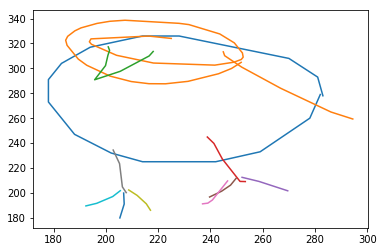

In [27]:
draw_strokes(inp+a)

# From SketchRNN to a-painter